In [96]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


# Model Evaluation on PlantVillage Dataset

This notebook evaluates the trained model using the test set. It includes metrics, confusion matrix, ROC curves, and a classification report.

In [97]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64


In [98]:
import tensorflow_datasets as tfds
from preprocessing import preprocess

# Load Trained Model and Test Data
arch_choice = 4  # Choose the architecture version
if arch_choice not in [1, 2, 3, 4]:
    raise ValueError("Invalid architecture choice")

model = keras.models.load_model(f'best_model_v{arch_choice}.h5')

ds_info = tfds.builder('plant_village').info
ds_test = tfds.load('plant_village', split='train[95%:]', as_supervised=True)

test_ds = ds_test.map(lambda image, label: preprocess(image, label, ds_info, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
class_names = ds_info.features['label'].names


In [99]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 [==============================] - 0s 56ms/step


In [100]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.726703
Precision: 0.802969
Recall: 0.726703
F1-score: 0.728585


In [101]:
# # Plot Confusion Matrix
# cm = confusion_matrix(y_true, y_pred, normalize='true')
# plt.figure(figsize=(14, 12))
# sns.heatmap(cm, annot=False, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix (Test Set)')
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()


<Figure size 640x480 with 0 Axes>

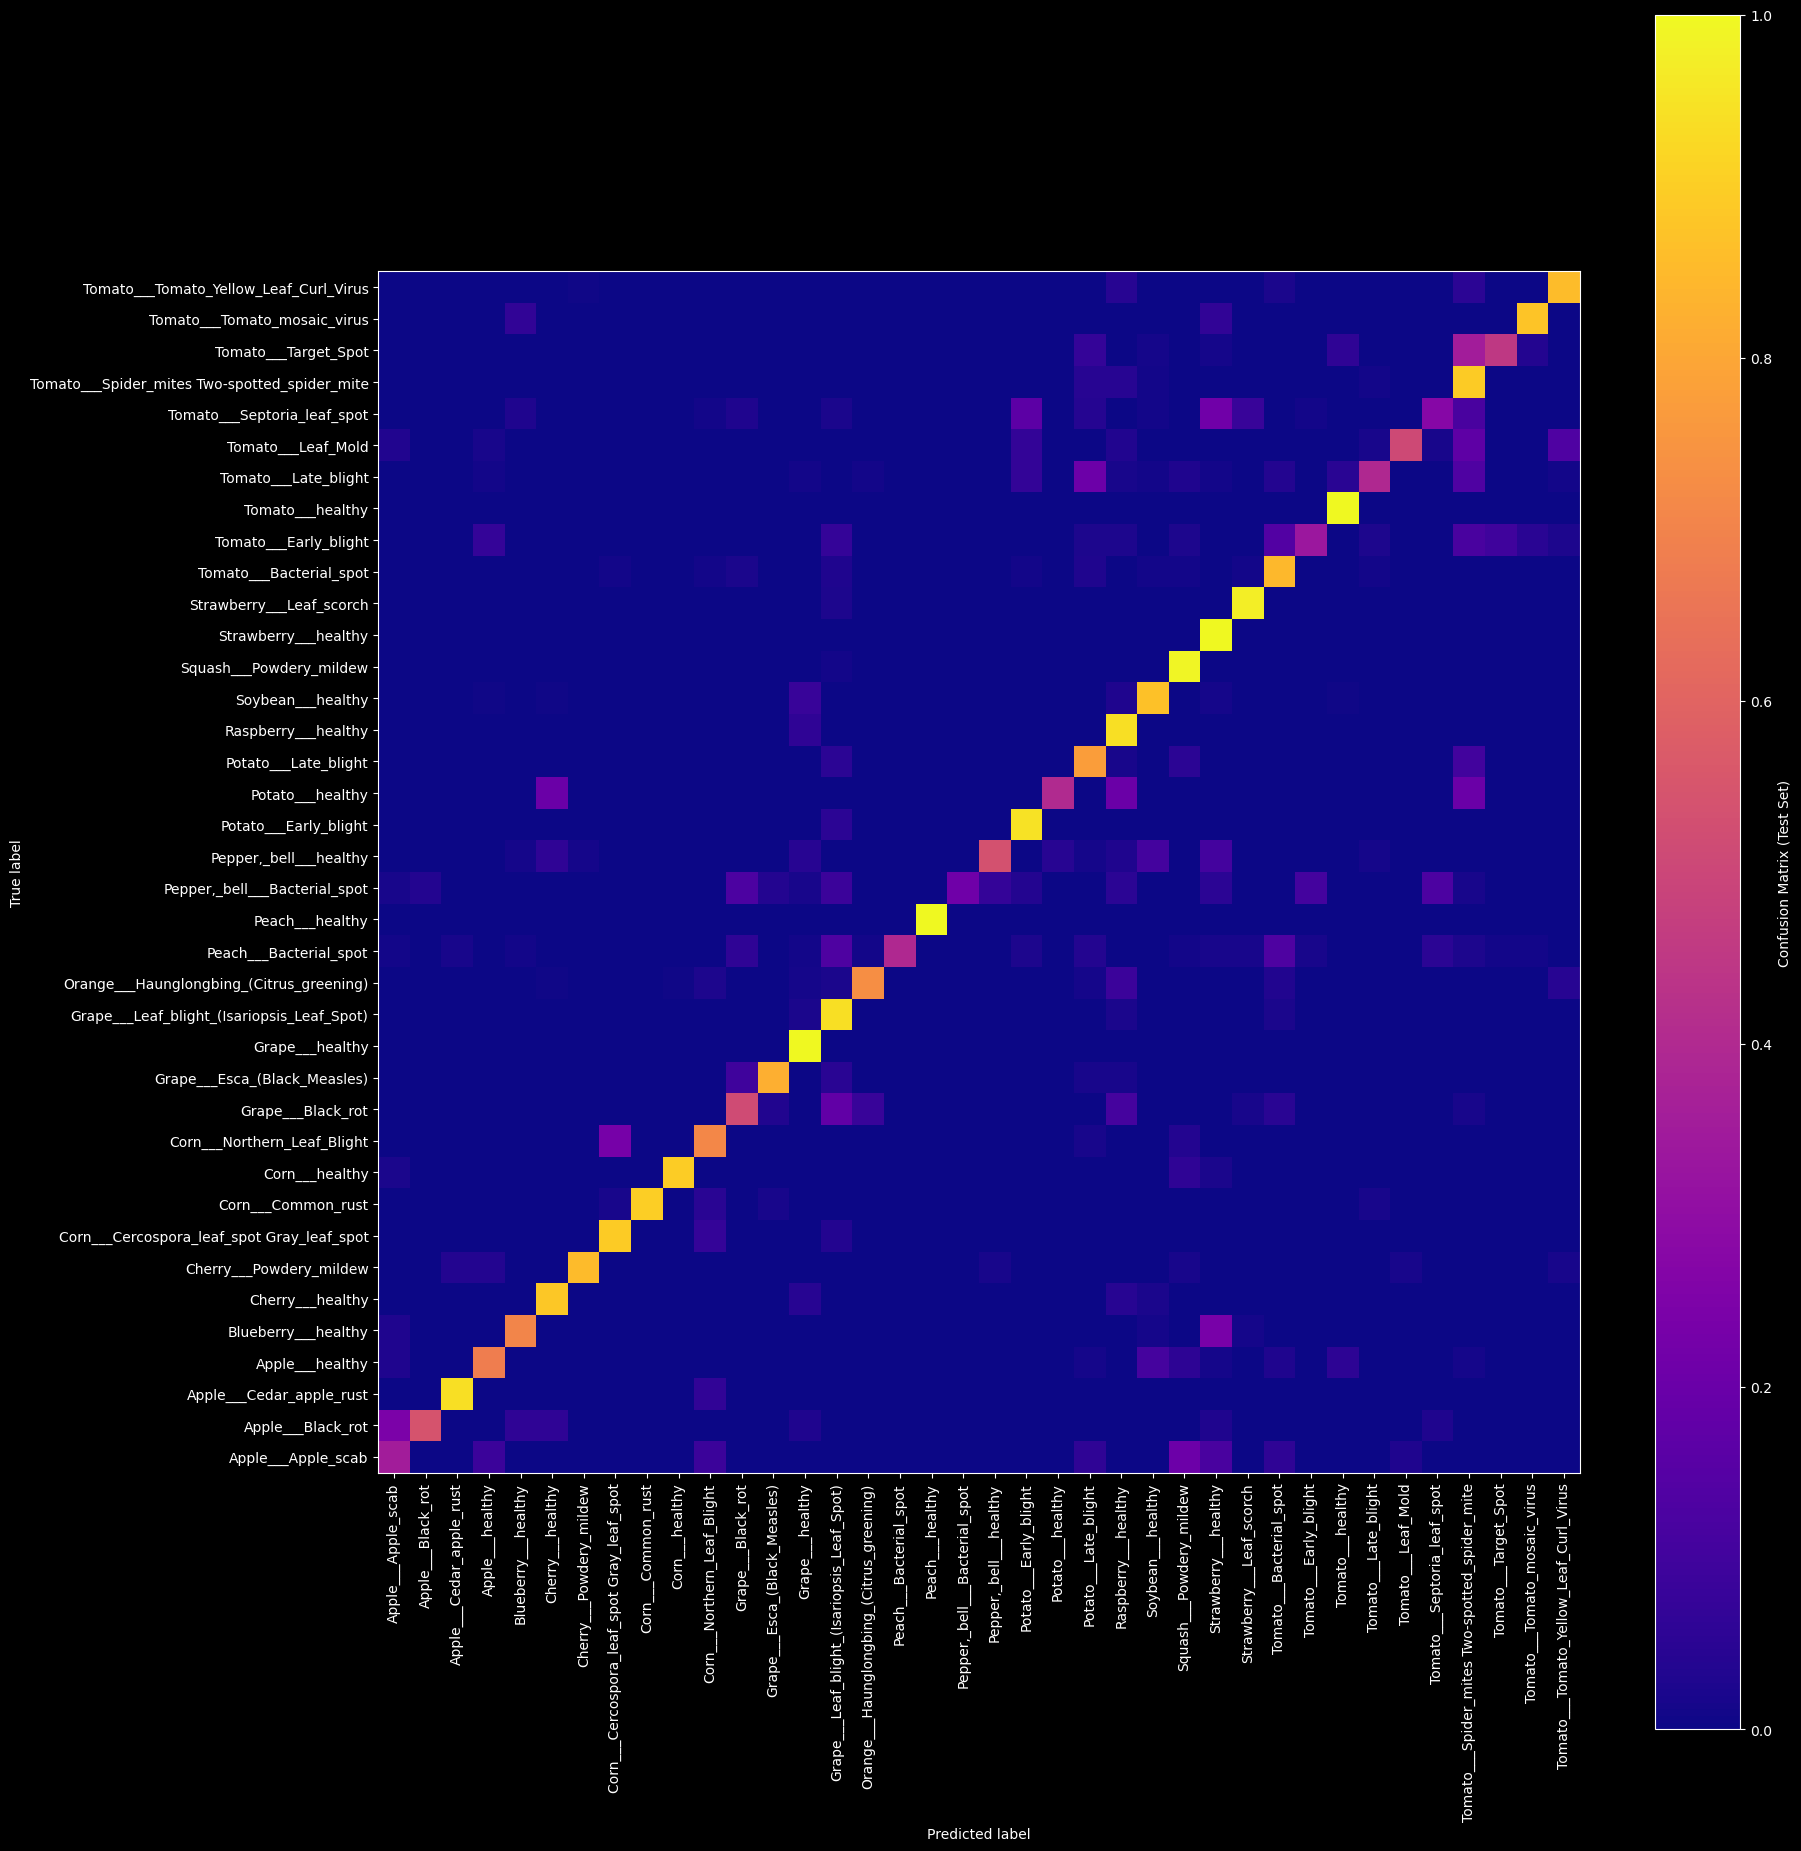

In [102]:
import matplotlib.pyplot as plt
from plotting import plot_confusion_matrix

plt.figure()  # Set a larger figure size for better readability
plot_confusion_matrix(
    np.array(y_true),
    np.array(y_pred),
    classes=class_names,
    normalize=True,
    title="Confusion Matrix (Test Set)",
    cmap="plasma"
)
plt.tight_layout()  # Ensure labels and ticks are not cut off
plt.savefig(f'./conf-matrix/confusion_matrix_v{arch_choice}.png', dpi=400, bbox_inches='tight')
plt.show()


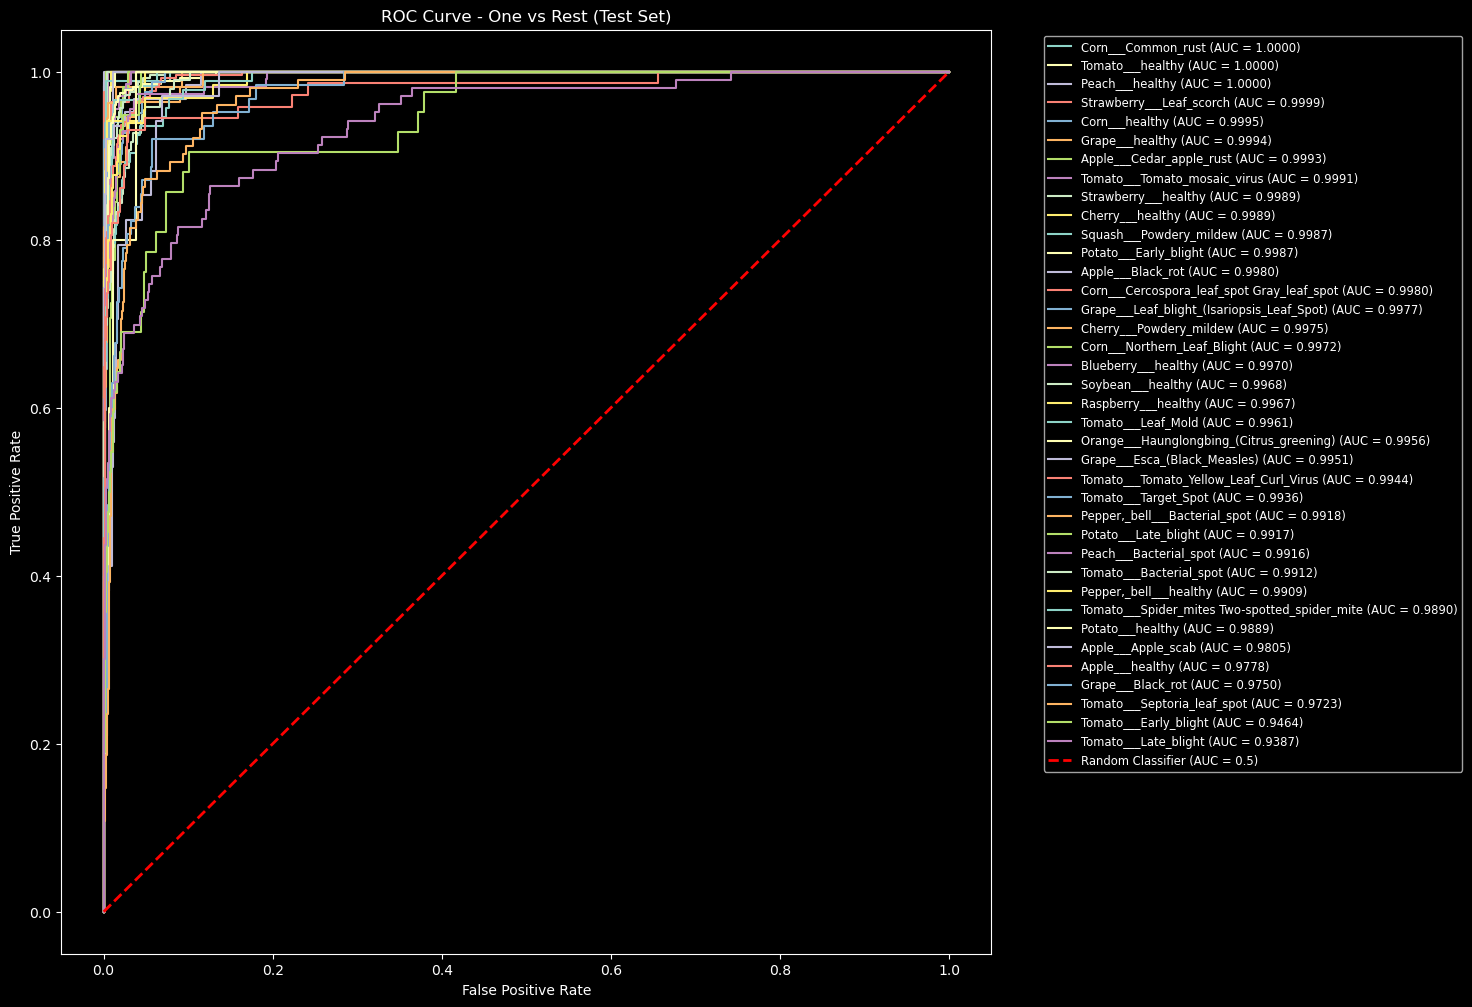

In [103]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.savefig(f'./roc-curves/roc_curve_v{arch_choice}.png', dpi=400, bbox_inches='tight')
plt.show()


In [104]:
# from plotting import make_roc
# fig, ax = plt.subplots(figsize=(16, 8))
# make_roc(np.eye(len(class_names))[y_true], y_score, class_names)
# # Move legend to a dedicated column outside the plot
# plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize="x-small", frameon=False)
# plt.subplots_adjust(right=0.75)  # Make space for the legend
# plt.show()


In [105]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save the classification report to a text file
with open(f'./reports/report_v{arch_choice}.txt', 'w') as f:
    f.write(report)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.41      0.35      0.38        34
                            Apple___Black_rot       0.90      0.55      0.68        33
                     Apple___Cedar_apple_rust       0.75      0.94      0.83        16
                              Apple___healthy       0.82      0.68      0.74        72
                          Blueberry___healthy       0.86      0.71      0.77        68
                             Cherry___healthy       0.80      0.89      0.84        44
                      Cherry___Powdery_mildew       0.94      0.85      0.89        54
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.62      0.89      0.74        28
                           Corn___Common_rust       1.00      0.90      0.95        60
                               Corn___healthy       0.96      0.90      0.93        49
                  Corn___Northern_Leaf_Bli